# Experimentation Only

In [1]:
import sys
!{sys.executable} -m pip install tqdm

You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from datetime import datetime
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#For Prediction
from sklearn import metrics
from sklearn import preprocessing, cross_validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers import Dense, Dropout, Input, LSTM, Activation, Flatten
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm, tqdm_notebook
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Read Datasets 
#research_data_raw = pd.read_csv('Datasets/bitcoin_research_data_v2.csv')
# Drop unnecessary columns
#research_data = research_data_raw.drop('Unnamed: 0', axis=1)
research_data = pd.read_csv('Datasets/gemini_BTCUSD_1hr_mod.csv')
#research_data.fillna(0, inplace=True)
research_data.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1559433600000,2019-06-02 00:00:00,BTCUSD,8566.10,8567.20,8546.38,8567.20,0.899330
1,1559430000000,2019-06-01 23:00:00,BTCUSD,8587.25,8598.10,8527.58,8566.10,156.493022
2,1559426400000,2019-06-01 22:00:00,BTCUSD,8598.89,8604.16,8542.44,8587.25,11.841891
3,1559422800000,2019-06-01 21:00:00,BTCUSD,8543.90,8609.96,8541.67,8598.89,18.957024
4,1559419200000,2019-06-01 20:00:00,BTCUSD,8538.75,8569.69,8532.23,8543.90,18.051794


In [4]:
research_data.tail()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
31975,1444323600,2015-10-08 17:00:00,BTCUSD,244.25,244.99,244.02,244.99,3.920632
31976,1444320000,2015-10-08 16:00:00,BTCUSD,244.92,244.92,244.25,244.25,3.895252
31977,1444316400,2015-10-08 15:00:00,BTCUSD,245.00,245.00,244.92,244.92,3.016926
31978,1444312800,2015-10-08 14:00:00,BTCUSD,245.00,245.00,244.50,245.00,4.453649
31979,1444309200,2015-10-08 13:00:00,BTCUSD,0.00,245.00,0.00,245.00,0.606654


In [5]:
len(research_data)

31980

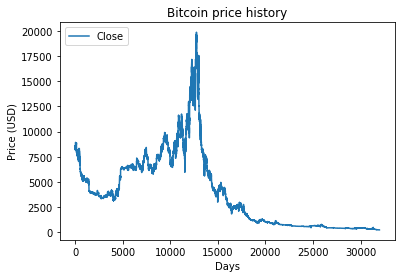

In [6]:
# plt.figure()
# plt.plot(research_data["Close"])
# plt.plot(research_data["High"])
# plt.plot(research_data["Low"])
# plt.plot(research_data["Close"])
# plt.title('Bitcoin price history')
# plt.ylabel('Price (USD)')
# plt.xlabel('Days')
# plt.legend(['Open','High','Low','Close'], loc='upper left')
# plt.show()

plt.figure()
plt.plot(research_data["Close"])
plt.title('Bitcoin price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Close'], loc='upper left')
plt.show()

In [7]:
# Normalize and convert DataFrame into ndArray
# train_cols = ["Open","High","Low","Close","Volume USD","Popularity_Normalized"]
# train_cols = ["Close","TransactionsPerBlock","USD_Exchange_Trade_Volume","BlockSize_d","Total_Number_of_Transactions_d","Close_d2"]
train_cols = ["Close","Volume"]

df_train, df_test = train_test_split(research_data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))

# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 25584 6396


In [8]:
TIME_STEPS = 15
BATCH_SIZE = 8
LR = 0.005
# epochs = 150
EPOCHS = 50

In [9]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [10]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [11]:
x_t, y_t = build_timeseries(x_train, 0) # index of output (3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 0) # index of output (3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

HBox(children=(IntProgress(value=0, max=25569), HTML(value='')))


length of time-series i/o (25569, 15, 2) (25569,)


HBox(children=(IntProgress(value=0, max=6381), HTML(value='')))


length of time-series i/o (6381, 15, 2) (6381,)


In [12]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
# lstm_model.add(Dropout(0.5))
# lstm_model.add(Dense(20,activation='relu'))
# lstm_model.add(Dense(1,activation='sigmoid'))
# optimizer = RMSprop(lr=LR)
# lstm_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# lstm_model = Sequential()
# lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform', return_sequences=True))
# lstm_model.add(Dropout(0.5))
# lstm_model.add(LSTM(32, return_sequences=True))
# #lstm_model.add(Dense(20,activation='relu'))
# lstm_model.add(LSTM(16, return_sequences=False))
# lstm_model.add(Dropout(0.5))
# lstm_model.add(Dense(1,activation='sigmoid'))
# optimizer = RMSprop(lr=LR, decay=3e-8)
# lstm_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# BEST SO FAR
# lstm_model = Sequential()
# lstm_model.add(LSTM(32, input_shape=(TIME_STEPS, x_t.shape[2]), return_sequences=True))
# lstm_model.add(Dropout(0.4))
# lstm_model.add(LSTM(16, return_sequences=False))
# lstm_model.add(Dense(1))
# lstm_model.add(Activation('tanh'))
# optimizer = RMSprop(lr=0.005, clipvalue=1.)
# lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# lstm_model = Sequential()
# lstm_model.add(LSTM(32, input_shape=(TIME_STEPS, x_t.shape[2]), return_sequences=True))
# lstm_model.add(Dropout(0.4))
# lstm_model.add(LSTM(16, return_sequences=False))
# lstm_model.add(Dense(1))
# lstm_model.add(Activation('tanh'))
# optimizer = RMSprop(lr=0.005, clipvalue=1.)
# lstm_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# lstm_model = Sequential()
# lstm_model.add(LSTM(16, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform', return_sequences=True))
# lstm_model.add(Dense(8,activation='relu'))
# lstm_model.add(Dropout(0.7))
# lstm_model.add(LSTM(8, return_sequences=False))
# lstm_model.add(Dense(1,activation='sigmoid'))
# optimizer = RMSprop(lr=LR, decay=3e-8)
# lstm_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])



# lstm_model = Sequential()
# lstm_model.add(LSTM(16, input_shape=(TIME_STEPS, x_t.shape[2]), return_sequences=False))
# lstm_model.add(Dropout(0.4))
# lstm_model.add(Dense(1))
# lstm_model.add(Activation('linear'))
# optimizer = RMSprop(lr=0.005, clipvalue=1.)
# lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])



lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activity_regularizer=regularizers.l1(1), input_shape=(TIME_STEPS, x_t.shape[2]),return_sequences=False))
lstm_model.add(Activation('tanh'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.add(LeakyReLU())
lstm_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
#lstm_model.fit(training_datas, training_labels, batch_size=batch_size,validation_data=(validation_datas,validation_labels), epochs = epochs, callbacks=[CSVLogger(output_file_name+'.csv', append=True)])



In [ ]:
# csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'your_log_name' + '.log'), append=True)

# history = model.fit(x_t, y_t, epochs=your_epochs, verbose=2, batch_size=BATCH_SIZE,
#                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
#                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

history = lstm_model.fit(x_t, y_t, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)))

Train on 25568 samples, validate on 3184 samples
Epoch 1/50
25568/25568 [==============================] - 36s 1ms/step - loss: 0.1492 - acc: 3.9111e-05 - val_loss: 0.0647 - val_acc: 3.1407e-04
Epoch 2/50
25568/25568 [==============================] - 36s 1ms/step - loss: 0.0449 - acc: 3.9111e-05 - val_loss: 0.0502 - val_acc: 3.1407e-04
Epoch 3/50
25568/25568 [==============================] - 36s 1ms/step - loss: 0.0378 - acc: 3.9111e-05 - val_loss: 0.0502 - val_acc: 3.1407e-04
Epoch 4/50
25568/25568 [==============================] - 36s 1ms/step - loss: 0.0359 - acc: 3.9111e-05 - val_loss: 0.0490 - val_acc: 3.1407e-04
Epoch 5/50
25568/25568 [==============================] - 37s 1ms/step - loss: 0.0357 - acc: 3.9111e-05 - val_loss: 0.0498 - val_acc: 3.1407e-04
Epoch 6/50
25568/25568 [==============================] - 49s 2ms/step - loss: 0.0357 - acc: 3.9111e-05 - val_loss: 0.0435 - val_acc: 3.1407e-04
Epoch 7/50
25568/25568 [==============================] - 49s 2ms/step - loss: 0.

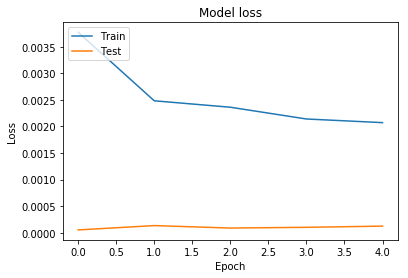

In [33]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['Train', 'Test', 'Train Accuracy', 'Test Accuracy'], loc='upper left')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))


In [34]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = metrics.mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.00019138544653278058 (3168,) (3168,)
[0.01038006 0.01036836 0.01043634 0.01055755 0.01061328 0.01058282
 0.01036726 0.00979245 0.00948539 0.0087962  0.00815761 0.00828005
 0.00869218 0.00926144 0.00990592]
[-0.00196204 -0.00203158 -0.00203158 -0.00193422 -0.00208978 -0.00173745
 -0.00190641 -0.00187395 -0.00187395 -0.00189868 -0.00189868 -0.00187447
 -0.00195998 -0.00187498 -0.00187498]


In [35]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[657.8733  657.6462  658.9659  661.3189  662.4009  661.8096  657.62476
 646.46564 640.5047  627.125   614.7278  617.1048  625.1055  636.15704
 648.6686 ]
[418.27 416.92 416.92 418.81 415.79 422.63 419.35 419.98 419.98 419.5
 419.5  419.97 418.31 419.96 419.96]


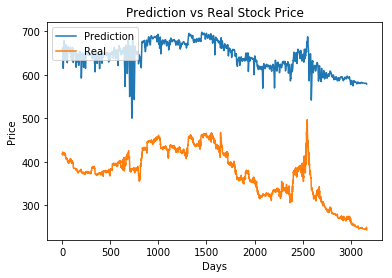

In [36]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
#plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))